In [28]:
#Importing required packages
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [29]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=15

In [30]:
#Converting image dataset into tf dataset that is in matrix form
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 26947 files belonging to 27 classes.


In [31]:
#name of classes
class_names = train_dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [32]:
len(train_dataset)

843

In [33]:
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[17 18 23 18  3 26 23 19 26 15 13 22 21 17  4 21  0  9 22 10 25 19 13 23
 24 24  7 23 20 19 17 13]


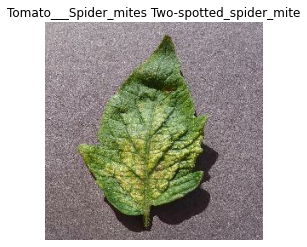

In [34]:
for image_batch, label_batch in train_dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[0]])

In [35]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6726 files belonging to 27 classes.


In [36]:
def test_dataset_partitions(test_dataset, val_split=0.5, test_split=0.5, shuffle=True, shuffle_size=10000):
    
    test_dataset_size = len(test_dataset)
    
    if shuffle:
        test_dataset.shuffle(shuffle_size, seed=10)
        
    val_size = int(val_split*test_dataset_size)
    test_size = int(test_split*test_dataset_size)
    
    validate_ds = test_dataset.take(val_size)
    test_ds = test_dataset.skip(val_size)
    
    return validate_ds, test_ds

In [37]:
validate_ds, test_ds = test_dataset_partitions(test_dataset)

In [38]:
len(validate_ds)

105

In [39]:
len(test_ds)

106

In [40]:
#caching and prefetching

In [41]:
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validate_ds = validate_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
#to resize and scale the image it will work also when new image is given
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [43]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [38]:
#Implementing CNN model which is manually designed.
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=27

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [39]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
#Fitting CNN model on dataset 
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validate_ds
)

Epoch 1/15
843/843 [==============================] - 5969s 7s/step - loss: 2.4911 - accuracy: 0.2777 - val_loss: 1.8701 - val_accuracy: 0.4336
Epoch 2/15
843/843 [==============================] - 1577s 2s/step - loss: 1.4222 - accuracy: 0.5620 - val_loss: 1.4896 - val_accuracy: 0.5583
Epoch 3/15
843/843 [==============================] - 1581s 2s/step - loss: 0.9236 - accuracy: 0.7080 - val_loss: 1.0664 - val_accuracy: 0.6881
Epoch 4/15
843/843 [==============================] - 1591s 2s/step - loss: 0.6931 - accuracy: 0.7791 - val_loss: 0.6710 - val_accuracy: 0.7857
Epoch 5/15
843/843 [==============================] - 1517s 2s/step - loss: 0.5301 - accuracy: 0.8278 - val_loss: 0.4856 - val_accuracy: 0.8375
Epoch 6/15
843/843 [==============================] - 1611s 2s/step - loss: 0.4456 - accuracy: 0.8518 - val_loss: 0.7798 - val_accuracy: 0.7842
Epoch 7/15
843/843 [==============================] - 1695s 2s/step - loss: 0.3750 - accuracy: 0.8748 - val_loss: 0.4327 - val_accuracy:

In [43]:
#Accuracy over test dataset
scores = model.evaluate(test_ds)

106/106 [==============================] - 45s 364ms/step - loss: 0.2587 - accuracy: 0.9168


In [44]:
history.history['accuracy']

[0.2776561379432678,
 0.5619549751281738,
 0.7079823613166809,
 0.7790848612785339,
 0.8278101682662964,
 0.8517831563949585,
 0.8747541308403015,
 0.8857758045196533,
 0.8922328948974609,
 0.9001001715660095,
 0.9107507467269897,
 0.9150925874710083,
 0.9258544445037842,
 0.9291943311691284,
 0.9337588548660278]

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

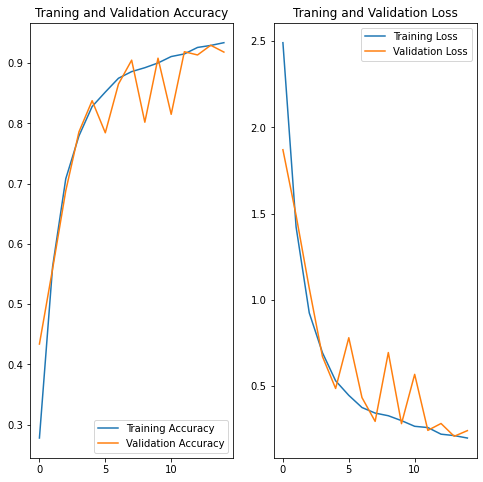

In [47]:
#Graph represent the working of model on train and test dataset
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Traning and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Traning and Validation Loss')
plt.show()

First image to predict
Actual label: Grape___Esca_(Black_Measles)
1/1 [==============================] - 2s 2s/step
Predicted label: Grape___Esca_(Black_Measles)


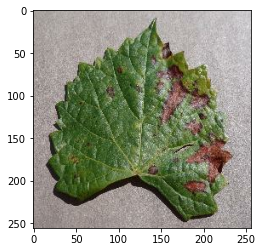

In [48]:
#Run prediction on sample image

import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [49]:
#Function for inference
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0)
    
    predictions=model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 66ms/step


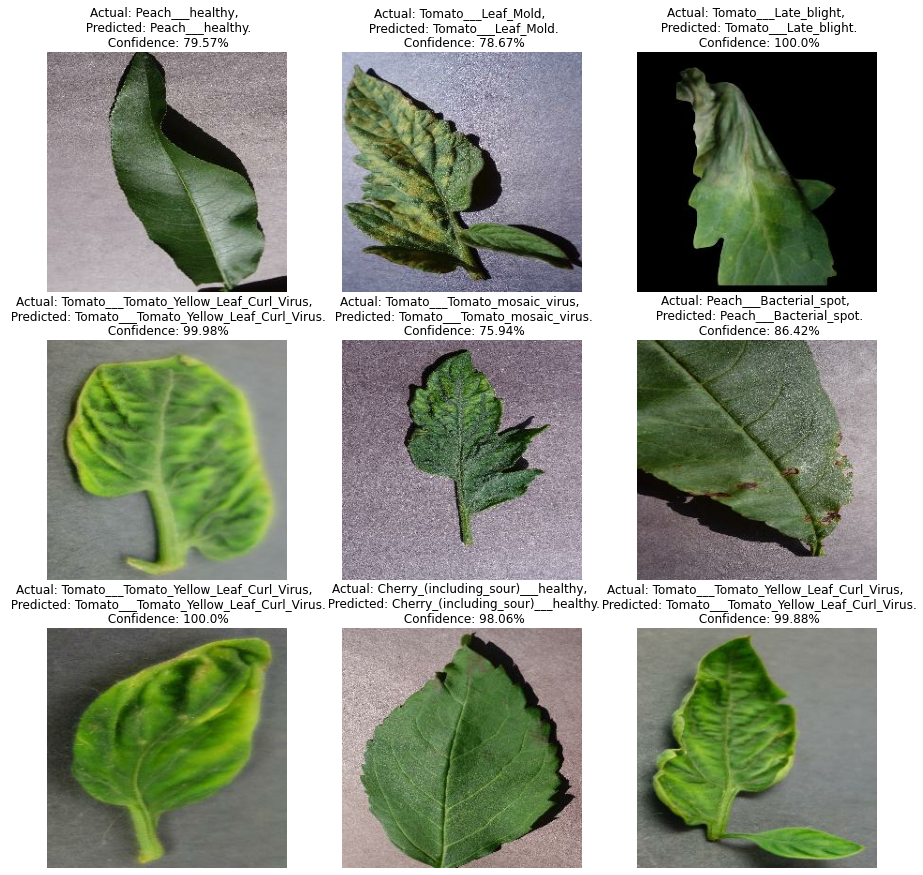

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [57]:
#Saving the trained model
import os
model.save("Model\plant_diseases")

INFO:tensorflow:Assets written to: Model\plant_diseases\assets


INFO:tensorflow:Assets written to: Model\plant_diseases\assets


In [58]:
model.save("Model\plant_diseases.h5")

# Implementing VGG16

In [44]:
#Importing packages
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [21]:
vgg = VGG16(input_shape=[IMAGE_SIZE,IMAGE_SIZE] + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 50s 1us/step


In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [25]:
n_classes=27
x = Flatten()(vgg.output)

prediction = Dense(n_classes, activation='softmax')(x)

In [26]:
model_vgg = Model(inputs=vgg.input, outputs=prediction)

In [27]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [28]:
model_vgg.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    #loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy']
)

In [30]:
history_vgg = model_vgg.fit(
    train_ds,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validate_ds
)

Epoch 1/5
843/843 [==============================] - 9957s 12s/step - loss: 4.4292 - accuracy: 0.8867 - val_loss: 3.3842 - val_accuracy: 0.9190
Epoch 2/5
843/843 [==============================] - 9738s 12s/step - loss: 1.7061 - accuracy: 0.9591 - val_loss: 3.9873 - val_accuracy: 0.9354
Epoch 3/5
843/843 [==============================] - 10103s 12s/step - loss: 1.2921 - accuracy: 0.9712 - val_loss: 4.1245 - val_accuracy: 0.9345
Epoch 4/5
843/843 [==============================] - 9688s 11s/step - loss: 0.9074 - accuracy: 0.9807 - val_loss: 4.4097 - val_accuracy: 0.9411
Epoch 5/5
843/843 [==============================] - 10634s 13s/step - loss: 0.8831 - accuracy: 0.9828 - val_loss: 5.9397 - val_accuracy: 0.9390


In [31]:
scores = model_vgg.evaluate(test_ds)

106/106 [==============================] - 1149s 11s/step - loss: 7.4822 - accuracy: 0.9337


In [33]:
history_vgg.history['accuracy']

[0.8867035508155823,
 0.9591420292854309,
 0.9711655974388123,
 0.9806657433509827,
 0.9827809929847717]

In [34]:
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']

loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (5,) and (3,)

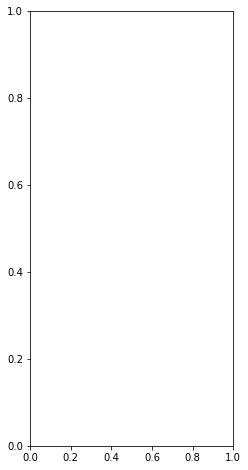

In [56]:
#Graph represent the working of model on train and test dataset
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(5), acc, label='Training Accuracy VGG')
plt.plot(range(5), val_acc, label='Validation Accuracy VGG')
plt.legend(loc='lower right')
plt.title('Traning and Validation Accuracy VGG')

plt.subplot(1, 2, 2)
plt.plot(range(5), loss, label='Training Loss VGG')
plt.plot(range(5), val_loss, label='Validation Loss VGG')
plt.legend(loc='upper right')
plt.title('Traning and Validation Loss VGG')
plt.show()

First image to predict
Actual label: Potato___Late_blight
1/1 [==============================] - 13s 13s/step
Predicted label: Potato___Late_blight


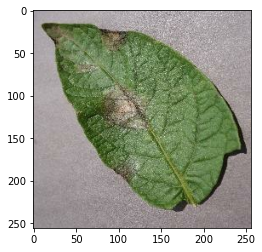

In [38]:
#Run prediction on sample image

import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction=model_vgg.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
import os
model_vgg.save("Model\plant_diseases_vgg")

INFO:tensorflow:Assets written to: Model\plant_diseases_vgg\assets


INFO:tensorflow:Assets written to: Model\plant_diseases_vgg\assets


In [41]:
model_vgg.save("Model\plant_diseases_vgg.h5")

# Implementing Xception

In [45]:
from keras.applications.xception import Xception

In [46]:
xception = Xception(input_shape=[IMAGE_SIZE,IMAGE_SIZE] + [3], weights='imagenet', include_top=False)

In [47]:
for layer in xception.layers:
    layer.trainable = False

In [48]:
n_classes=27
x = Flatten()(xception.output)

prediction = Dense(n_classes, activation='softmax')(x)

In [49]:
model_xception = Model(inputs=xception.input, outputs=prediction)

In [50]:
model_xception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [51]:
model_xception.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    #loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy']
)

In [52]:
history_xception = model_xception.fit(
    train_ds,
    epochs=3,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validate_ds
)

Epoch 1/3
843/843 [==============================] - 4355s 5s/step - loss: 112.5312 - accuracy: 0.4890 - val_loss: 94.4404 - val_accuracy: 0.5899
Epoch 2/3
843/843 [==============================] - 3821s 5s/step - loss: 76.7139 - accuracy: 0.6499 - val_loss: 94.2503 - val_accuracy: 0.6452
Epoch 3/3
843/843 [==============================] - 3018s 4s/step - loss: 64.3509 - accuracy: 0.7058 - val_loss: 102.8297 - val_accuracy: 0.6244


In [53]:
scores = model_xception.evaluate(test_ds)

106/106 [==============================] - 328s 3s/step - loss: 103.4860 - accuracy: 0.6168


In [55]:
acc = history_xception.history['accuracy']
val_acc = history_xception.history['val_accuracy']

loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']

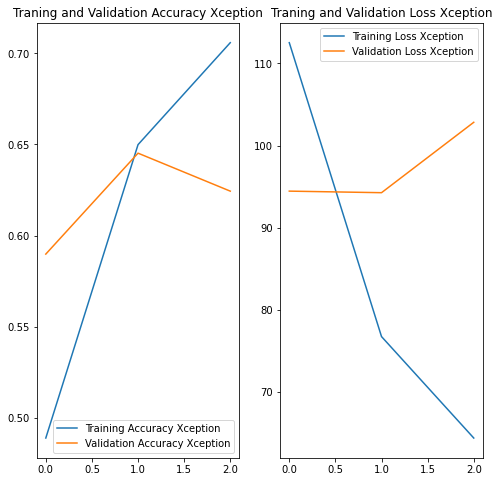

In [58]:
#Graph represent the working of model on train and test dataset
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(3), acc, label='Training Accuracy Xception')
plt.plot(range(3), val_acc, label='Validation Accuracy Xception')
plt.legend(loc='lower right')
plt.title('Traning and Validation Accuracy Xception')

plt.subplot(1, 2, 2)
plt.plot(range(3), loss, label='Training Loss Xception')
plt.plot(range(3), val_loss, label='Validation Loss Xception')
plt.legend(loc='upper right')
plt.title('Traning and Validation Loss Xception')
plt.show()

In [59]:
import os
model_xception.save("Model\plant_diseases_xception")

INFO:tensorflow:Assets written to: Model\plant_diseases_xception\assets


INFO:tensorflow:Assets written to: Model\plant_diseases_xception\assets


In [60]:
model_xception.save("Model\plant_diseases_xception.h5")